In [75]:
import sys
import os
print(sys.version)

3.6.10 |Anaconda, Inc.| (default, May  8 2020, 02:54:21) 
[GCC 7.3.0]


In [76]:
import random
import sys
import datetime
import cv2
import numpy as np
import operator
import imutils
import matplotlib.pyplot as plt

#debug info OpenCV version
print ("OpenCV version: " + cv2.__version__)

OpenCV version: 4.2.0


In [77]:
#define constants
imagePath = "dataset/test.jpg" #specify your path here
scale_percent = 20  # percentage by which image size will be reduced


In [79]:
def display_image(img, title):
    cv2.imshow(title,img) 
    # here it should be the pause ,0 means indefinitely
    k = cv2.waitKey(0)
    if k == 27:         # wait for ESC key to exit
        cv2.destroyAllWindows()

In [80]:
img = cv2.imread(imagePath)

print('Original Dimensions : ',img.shape)

width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('Resized Dimensions : ',img.shape)

#Grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

display_image(img,"GrayResized")

Original Dimensions :  (3264, 2448, 3)
Resized Dimensions :  (652, 489, 3)


In [81]:
#Processing the image
img = cv2.GaussianBlur(img, (9 ,9), 0)
display_image(img,"GausianBlur")

In [82]:
# Adaptive threshold using 11 nearest neighbour pixels
# If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value.
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
display_image(img,"AdaptiveThreshold")

In [83]:
# Invert colours, so gridlines have non-zero pixel values.
img = cv2.bitwise_not(img);
display_image(img,"BitwiseNot")

In [84]:
#increases the white region in the image or size of foreground object increases.This makes gridlines prominent
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
img = cv2.dilate(img, kernel)
display_image(img,"Dilated")

In [85]:
def get_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""

    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    # Largest image
    polygon = contours[0]  
 
    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # return np array of size 4 representing the four corners' x and y coordinates
    arr = np.array([polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]], dtype='float32')
    return arr

In [86]:
rect_corners = get_corners_of_largest_polygon(img)

In [87]:
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

In [88]:
def get_bird_view_image(img, src_point):
    """bird's eye view of the given board from the corresponding src_point."""

    # Get the longest side in the rectangle
    side = max([
        distance_between(src_point[2], src_point[1]),
        distance_between(src_point[0], src_point[3]),
        distance_between(src_point[2], src_point[3]),
        distance_between(src_point[0], src_point[1])
        ])
    
    print(side)

    dst_points = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    m = cv2.getPerspectiveTransform(src_point, dst_points)

    # Performs the transformation on the original image
    warp = cv2.warpPerspective(img, m, (int(side), int(side)))
    plt.imshow(warp, cmap='gray')
    plt.title('warp_image')
    plt.show()
    return warp

426.0422514258416


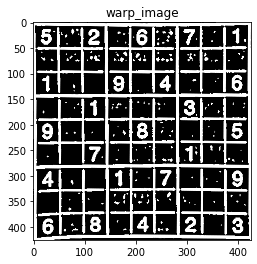

In [89]:
cropped = get_bird_view_image(img,rect_corners)
display_image(cropped,"wrapped")